# 03_IBM-HHRR_ATTRITION_Ranking_V1

## 0 - Previous Tasks

To run this notebook, the following folders generated in previous notebooks are required:

01 - Default files -----------------> C:\TFM\01_default # Contains the models in default state. 

02 - Total models files------------> C:\TFM\02_total_models # Contains the models with the main parameter.


The notebook will generate the following folders: 

03 - Complete model files--------> C:\TFM\03_complete_model # Contains the models that pass the parameter phase.

04 - Best model files--------------> C:\TFM\04_best_model # Contains the best model from the parameter phase by algorithm.

05 - F2 Score Graph files----------> C:\TFM\05_Photos_F2-Score_Results # Contains the F2 Score graphs of the algorithms.

### Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML  # Importar HTML para aplicar formato

### Load Files

#### Input files: Default & Total_models

In [2]:
# MODELS and DISTRIBUTION files:

# Load models
model_list = ['regression_logistic', 'adaboost','xgboost','catboost', 'decision_tree', 'random_forest', 'mlp', 'knn']

# Load distribution
distribution_list = ['_OR_origin', '_OR_smote', '_OR_adasyn', '_PT_origin', '_PT_smote', '_PT_adasyn']

# Load default files:
default_list = ['_default']

# Load PATHS:
default_path = r'C:\HHRR\01_default'
model_path = r'C:\HHRR\02_total_models'
list_total =['_total']

print("default_path:", default_path)
print("\nmodel_path:  ", model_path)

default_path: C:\HHRR\01_default

model_path:   C:\HHRR\02_total_models


## Save Files

#### Output files: Complete model, Best model, Photos F2 Score

In [3]:
# Define general path:
path_general = r'C:\HHRR'
best_model = ['_best_model']

# General path subfolders:
complete_model_directory = os.path.join(path_general, '03_complete_model')
best_model_directory = os.path.join(path_general, '04_best_model')
path_photos = os.path.join(path_general, '05_Photos_F2-Score_Results')

print("Path Complete Model:", complete_model_directory)
print("\nPath Best Model    :", best_model_directory)
print("\nPath Photos:       :", path_photos)

Path Complete Model: C:\HHRR\03_complete_model

Path Best Model    : C:\HHRR\04_best_model

Path Photos:       : C:\HHRR\05_Photos_F2-Score_Results


### Functions:

In [4]:
def load_files(primary_list, secundary_list, path):
    """
    Loads CSV files based on combinations of two input lists and saves them as dynamic global variables.

    Parameters:
    -----------
    primary_list : list
        A list of primary values used to generate file names.
        
    secundary_list : list
        A list of secondary values used to generate file names.
        
    path : str
        The directory path where the CSV files are located.

    Description:
    ------------
    This function iterates over both `primary_list` and `secundary_list` to create file names by combining the elements
    of both lists, assuming the files are CSVs. It uses the helper function `load_csv_default` to load the files.

    - If the file is found, it loads the CSV, removes the "Unnamed: 0" column (if it exists), and saves the loaded 
      data as a dynamically named global variable.
    - If the file is not found, it prints an error message.

    The dynamic variable is created using `globals()` with the file name (excluding the `.csv` extension).

    Helper Function:
    ----------------
    load_csv_default(file_name, path):
        Loads the CSV file from the given path and handles any missing columns or file-not-found errors.

        Parameters:
        -----------
        file_name : str
            The name of the file to load.

        path : str
            The directory path where the CSV file is located.

        Returns:
        --------
        data : pd.DataFrame or None
            Returns the loaded DataFrame if the file is found, otherwise returns None.
    """
    
    def load_csv_default(file_name, path):
        
        # Join path and file_name 
        full_path = os.path.join(path, file_name)
        
        try:
            # Load file CSV and delete column 'Unnamed: 0 ' if exists
            data = pd.read_csv(full_path).drop(columns=["Unnamed: 0"], errors='ignore')  
            print(f"File Load: {file_name} .")  # Confirmar que el archivo fue cargado
            return data
        except FileNotFoundError:
            print(f"File Not Found: {full_path} .")
            return None

    # Iterate over both lists
    for primary in primary_list:
        for secundary in secundary_list:
            # Create name fila and concatenate value of both list
            file_name = f"{primary}{secundary}.csv"  # Assuming extensión CSV
            # Load file CSV
            data = load_csv_default(file_name, path)
            if data is not None:
                # Create dinamic variable  using globals()
                globals()[file_name.replace('.csv', '')] = data

In [5]:
def add_default(dataframe):
    """
    Adds a new column labeled 'Parameter' with the value 'Default' before the 'ROC-AUC' column.

    Parameters:
    -----------
    dataframe : pd.DataFrame
        The input DataFrame to which the new 'Parameter' column will be added.

    Returns:
    --------
    pd.DataFrame
        The modified DataFrame with the new 'Parameter' column added.

    Description:
    ------------
    This function inserts a new column called 'Parameter' into the given DataFrame, positioning it just before the 
    'ROC-AUC' column. Every row in the new 'Parameter' column is populated with the value 'Default'.
    """
    dataframe.insert(dataframe.columns.get_loc('ROC-AUC'), 'Parameter', 'Default')
    return(dataframe)

In [6]:
def create_ranking(model_list, extension):
    """
    Generates a ranking of models based on the highest 'F2 Score' from a list of models.

    Parameters:
    -----------
    model_list : list
        A list of model names used to build the variable names (as DataFrames) that will be ranked.
    
    extension : str
        The file extension or suffix to append to each model name when constructing the variable names.

    Returns:
    --------
    pd.DataFrame
        A concatenated DataFrame of the best parameters for each model, ranked by 'F2 Score'.

    Description:
    ------------
    This function processes a list of models, where each model is assumed to have a corresponding DataFrame 
    stored in global variables. The function does the following:

    1. Iterates over `model_list`, creating the variable name for each model by appending the given `extension`.
    2. Retrieves the corresponding DataFrame from the global variables.
    3. Identifies the row with the highest 'F2 Score' for each model.
    4. Stores the result in a list.
    5. Concatenates all the DataFrames into one and returns a final ranking DataFrame.

    The resulting DataFrame contains the best parameters (rows) from each model based on the highest 'F2 Score'.

    Example:
    --------
    If `model_list = ['model1', 'model2']` and `extension = '_results'`, the function will process global variables
    `model1_results` and `model2_results`, ranking them by their maximum 'F2 Score'.
    """
    # Create empty list to save F2-Scores:
    max_f2_scores = []
    
    print(f"Loading Files with extension '{extension}':\n")
    
    for model in model_list:
        # Build the name of the variable
        model_var_name = f"{model}{extension}"
        
        # Obtener el DataFrame correspondiente a esa variable usando globals()
        # Get DataFrame for variable using globals()
        model_df = globals()[model_var_name]
        print(f"Processing {model_var_name}")
        
        # Select row with highest 'F2 Score'
        max_f2_score = model_df['F2 Score'].max()

        data_best_param = model_df[model_df['F2 Score'] == max_f2_score]
        data_best_param = data_best_param.reset_index(drop=True)                            
        # Add result to list
        max_f2_scores.append(data_best_param) 
    print("\nRanking:")
    # Concatenate all dataframes 
    ranking = pd.concat(max_f2_scores)

    # Reset index
    ranking.reset_index(drop=True, inplace=True)

    return ranking

In [7]:
def models(model_f2score_result, data, save_directory_models=None):
    """
    Plots and saves F2 Score comparison graphs for different models and their parameters.

    Parameters:
    -----------
    model_f2score_result : list
        A list containing:
        - model_name_file (str): The file name of the model.
        - model_name (str): The name of the model.
        - f2_score (float): The F2 Score for the current model.
        - f2_max (float): The maximum F2 Score across all models.
        
    data : pd.DataFrame
        The DataFrame containing the F2 Scores for different models and parameters. 
        It must include a 'Description' column that categorizes the data, and an 'F2 Score' column for the scores.
        
    save_directory_models : str, optional
        The directory where the plot will be saved. If not provided, it defaults to a folder named 'f2-score_photos'
        in the current working directory.

    Returns:
    --------
    None
        The function saves the F2 Score graphs to the specified directory and also displays them on the screen.

    Description:
    ------------
    This function:
    1. Extracts F2 Score data for different descriptions ('OR origin', 'OR smote', 'OR adasyn', etc.) from the provided DataFrame.
    2. Compares F2 Scores across different parameter settings for the model.
    3. Creates a grid of subplots showing the F2 Score for each description (original, SMOTE, ADASYN) and for both 'OR' and 'PT'.
    4. Highlights the current model’s F2 Score, the best overall F2 Score, and marks the range where F2 Scores exceed the current model’s.
    5. Saves the resulting graph as a PNG file in the specified directory and shows the plot on the screen.

    The function also labels each subplot with:
    - The parameters that led to F2 Scores exceeding the current model's score.
    - The maximum F2 Score and its corresponding parameter value.

    Example:
    --------
    Given a model with name 'model1', the function plots F2 Scores for different descriptions (e.g., 'OR origin', 'OR smote', etc.)
    and saves the graph to a specified or default directory.
    """

    # Extract model's information 
    model_name_file = model_f2score_result[0] 
    model_name = model_f2score_result[1]  
    f2_score = round(model_f2score_result[2], 6)
    f2_max = round(model_f2score_result[3], 6)        

    # Create F2 Score lists
    OR_origin_list = data[data['Description'] == 'OR origin']['F2 Score'].to_list()
    OR_smote_list = data[data['Description'] == 'OR smote']['F2 Score'].to_list()
    OR_adasyn_list = data[data['Description'] == 'OR adasyn']['F2 Score'].to_list()

    PT_origin_list = data[data['Description'] == 'PT origin']['F2 Score'].to_list()
    PT_smote_list = data[data['Description'] == 'PT smote']['F2 Score'].to_list()
    PT_adasyn_list = data[data['Description'] == 'PT adasyn']['F2 Score'].to_list()
    
    # Get models adtional info:
    parameter_list = data[data['Description'] == 'OR origin']['Parameter'].to_list()
    parameter_name = parameter_list[0].split('=')[0].strip()
    parameter_values = [param.split('=')[1].strip() for param in parameter_list] 
    
    # Selected levels: Find the maximum F2 Score for each list
    OR_origin_max = round(max(OR_origin_list), 6)
    OR_smote_max = round(max(OR_smote_list), 6)
    OR_adasyn_max = round(max(OR_adasyn_list), 6)
    PT_origin_max = round(max(PT_origin_list), 6)
    PT_smote_max = round(max(PT_smote_list), 6)
    PT_adasyn_max = round(max(PT_adasyn_list), 6)
    
    # Max F2-Score for every model.
    horizontal_lines_values = [OR_origin_max, OR_smote_max, OR_adasyn_max,
                               PT_origin_max, PT_smote_max, PT_adasyn_max]
    
    # Create dataframe:
    df_f2score = pd.DataFrame({
        parameter_name: parameter_values,
        'OR_origin': OR_origin_list,
        'OR_smote': OR_smote_list,
        'OR_adasyn': OR_adasyn_list,
        'PT_origin': PT_origin_list,
        'PT_smote': PT_smote_list,
        'PT_adasyn': PT_adasyn_list
    })

    # Info to plot
    columns_to_plot = ['OR_origin', 'OR_smote', 'OR_adasyn', 'PT_origin', 'PT_smote', 'PT_adasyn']
    
    # Get the max F2-Score for each column
    columns_to_plot_max = list(round(df_f2score.drop(columns=[parameter_name]).max(), 6))
    
    # Set the style to ensure white background and readable plots
    plt.style.use('default')  # Reset to default style to avoid dark backgrounds

    # Create figure:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, column in enumerate(columns_to_plot):
        row = i // 3
        col = i % 3

        # Convert columns to axes
        x = df_f2score[parameter_name].values
        y = df_f2score[column].values

        # Graph subplot
        axes[row, col].plot(x, y, marker='o', label=column)

        # Add horizontal line from best F2 Score
        axes[row, col].axhline(y=f2_max, color='b', linestyle='--', label=f'F2 Max: {f2_max}')
        
        # Shade the area between the horizontal line and the plot values
        axes[row, col].fill_between(x, y, f2_score, where=(y > f2_score), 
                                     color='skyblue', alpha=0.4, label='Interval')
  
        # Add horizontal line for F2 Score for current model
        axes[row, col].axhline(y=f2_score, color='r', linestyle='--', label=f'F2 Mod: {f2_score}')
        
        # Get the learning rates (or parameters) that meet the condition
        relevant_parameters = x[y > f2_score]
        relevant_parameters_str = ', '.join(map(str, relevant_parameters))

        # Get the index of the maximum F2 Score
        max_f2_idx = y.argmax()
        max_f2_param = x[max_f2_idx]  # Corresponding parameter to the maximum F2 Score
        
        # Set the title and axis labels, including the max F2 Score and corresponding parameter
        axes[row, col].set_title(f"{column}\n[ {relevant_parameters_str} ] \nMax F2: {y[max_f2_idx]:.6f}, {parameter_name}: {max_f2_param}",
                                  fontweight='bold', fontsize=12)  # Include max F2 and parameter in title
        
        axes[row, col].set_xlabel(parameter_name, fontweight='bold')  # Bold X-axis label
        axes[row, col].set_ylabel('F2 Score', fontweight='bold')  # Bold Y-axis label

        # Titles and labels
        axes[row, col].set_ylabel('F2 Score', fontweight='bold')
        axes[row, col].set_ylim(0, 1)  # Limits for  Y de 0 a 1
        axes[row, col].set_yticks([i * 0.1 for i in range(11)])  # Ticks in 0.1
        axes[row, col].grid(True, which='both', linestyle='--', linewidth=0.7)
        axes[row, col].legend()

    # Principal Title
    fig.suptitle(f'{model_name}: F2 Score Results', fontsize=20, fontweight='bold')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    
    # Save path in selected directory or in current work directory
    if save_directory_models is None:
         save_directory_models = os.path.join(os.getcwd(), 'f2-score_photos') 
    
    # Build complete path of file using the name of model
    #save_path = os.path.join(save_directory_models, f"{model_name}_f2score_results.png")
    save_path = os.path.join(save_directory_models, f"{model_name_file}_f2score_results.png")
    
    # Create directory if not exicts
    os.makedirs(save_directory_models, exist_ok=True)
    
    # Save graph in the specified path
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')  
    
    # Show the graph in screen
    plt.show()

In [10]:
def model_table(model_f2score_result, data, save_directory_complete_model=None):
    """
    Saves a filtered table of models with F2 Scores exceeding a given threshold and exports it as a CSV file.

    Parameters:
    -----------
    model_f2score_result : list
        A list containing:
        - model_name_file (str): The file name for the model.
        - model_name (str): The name of the model.
        - f2_score_limit (float): The threshold F2 Score to filter the data.
        
    data : pd.DataFrame
        The DataFrame containing the F2 Scores and parameters for different models. It must include an 'F2 Score' column.
        
    save_directory_complete_model : str, optional
        The directory where the filtered table will be saved. If not provided, it defaults to a folder named 'complete_model'
        in the current working directory.

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing the models and their parameters where the F2 Score meets or exceeds the threshold.

    Description:
    ------------
    This function filters the provided DataFrame (`data`) to only include rows where the 'F2 Score' is greater than or equal to 
    the threshold defined in `model_f2score_result`. The resulting table is then saved as a CSV file in the specified directory.

    The default directory for saving is 'complete_model' within the current working directory. If the directory does not exist, 
    it is created. The filtered table is also returned as a DataFrame for further use.

    Example:
    --------
    If `model_f2score_result = ['model1', 'Model 1', 0.75]`, the function will filter the DataFrame to include only rows with 
    an F2 Score of 0.75 or higher and save the result as 'model1_f2score_table.csv' in the specified or default directory.
    """
    model_name_file = model_f2score_result[0]
    model_name = model_f2score_result[1]
    if data is None:
        print(f"El modelo {model_name} no existe.")
        return
    f2_score_limit = round(model_f2score_result[2], 6)
    data_param = data[data['F2 Score'] >= f2_score_limit].reset_index(drop=True)
    
    # Save in current work directory by default
    if save_directory_complete_model is None:
        save_directory_complete_model = os.path.join(os.getcwd(), 'complete_model')
        
    # Create path of file CSV using model name
    save_path = os.path.join(save_directory_complete_model, f"{model_name_file}_f2score_table.csv")
    
    # Create directory if not exists
    os.makedirs(save_directory_complete_model, exist_ok=True)
    
    # Save dataframe as CSV file
    data_param.to_csv(save_path, index=False)
    #print(f"Tabla guardada en {save_path}")
    
    return data_param

In [11]:
def best_model_table(model_f2score_result, data, save_directory_best_model=None):
    """
    Saves a filtered table of models with F2 Scores exceeding a given threshold and exports it as a CSV file.

    Parameters:
    -----------
    model_f2score_result : list
        A list containing:
        - model_name_file (str): The file name for the model.
        - model_name (str): The name of the model.
        - f2_score_limit (float): The threshold F2 Score to filter the data.
        
    data : pd.DataFrame
        The DataFrame containing the F2 Scores and parameters for different models. It must include an 'F2 Score' column.
        
    save_directory_complete_model : str, optional
        The directory where the filtered table will be saved. If not provided, it defaults to a folder named 'complete_model'
        in the current working directory.

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing the models and their parameters where the F2 Score meets or exceeds the threshold.

    Description:
    ------------
    This function filters the provided DataFrame (`data`) to only include rows where the 'F2 Score' is greater than or equal to 
    the threshold defined in `model_f2score_result`. The resulting table is then saved as a CSV file in the specified directory.

    The default directory for saving is 'complete_model' within the current working directory. If the directory does not exist, 
    it is created. The filtered table is also returned as a DataFrame for further use.

    Example:
    --------
    If `model_f2score_result = ['model1', 'Model 1', 0.75]`, the function will filter the DataFrame to include only rows with 
    an F2 Score of 0.75 or higher and save the result as 'model1_f2score_table.csv' in the specified or default directory.
    """
    model_name_file = model_f2score_result[0] 
    model_name = model_f2score_result[1]  
    if data is None:
        print(f"The model {model_name} does not exist.")
    f2_max = round(model_f2score_result[3], 6)
    
    # First, find the maximum value in the 'F2 Score' column
    max_f2_score = data['F2 Score'].max()

    # Then, filter the DataFrame to get all the rows that have that maximum value
    data_best_param = data[data['F2 Score'] == max_f2_score]

    # Reset the index of data_best_param and drop the old index
    data_best_param = data_best_param.reset_index(drop=True)

    # If you need the original indices of the rows that met the condition
    #indices_best_param = data_best_param.index.tolist()
    
    # Save in the current working directory by default
    if save_directory_best_model is None:
        save_directory_best_model = os.path.join(os.getcwd(), 'best_model')
        
    # Create the CSV file path using the model name
    save_path = os.path.join(save_directory_best_model, f"{model_name_file}_best_model.csv")
    
    # Create the directory if it doesn't exist
    os.makedirs(save_directory_best_model, exist_ok=True)
    
    # Save the DataFrame as a CSV file
    data_best_param.to_csv(save_path, index=False)
    #print(f"Table saved at {save_path}")
    
    return (data_best_param)

In [12]:
def full_model(model_f2score_result, data, 
               save_directory_models,
               save_directory_complete_model, 
               save_directory_best_model ): 
    """
    Displays and saves visualizations, full model tables, and the best model table for a given model.

    Parameters:
    -----------
    model_f2score_result : list
        A list containing:
        - model_name_file (str): The file name for the model.
        - model_name (str): The name of the model.
        - f2_score_limit (float): The threshold F2 Score for filtering the data.
        
    data : pd.DataFrame
        The DataFrame containing the model's F2 Scores, parameters, and descriptions. It should include a 'Description' 
        column and a 'F2 Score' column.
        
    save_directory_models : str
        The directory where the F2 Score plots for the model will be saved.
        
    save_directory_complete_model : str
        The directory where the full model table (with scores above the threshold) will be saved as a CSV file.
        
    save_directory_best_model : str
        The directory where the best model table (highest score) will be saved as a CSV file.

    Returns:
    --------
    None
        This function displays visual outputs and tables, and saves them to the specified directories.

    Description:
    ------------
    This function performs several tasks for a given model:
    
    1. **Display Model Information**: It displays the model name in a centered heading on screen.
    
    2. **Plot and Save F2 Score Graphs**: Calls the `models` function to generate F2 Score comparison plots and saves them 
       to the `save_directory_models`.
    
    3. **Generate and Save Full Model Table**: Displays and saves a table containing all the parameter configurations 
       where the F2 Score meets or exceeds the threshold. The table is saved in `save_directory_complete_model` using 
       the `model_table` function.
    
    4. **Generate and Save Best Model Table**: Displays and saves the best model table, containing the configuration 
       with the highest F2 Score, in `save_directory_best_model` using the `best_model_table` function.

    If the `data` is `None`, the function prints an error message stating that the model does not exist.

    Example:
    --------
    Given model results, it will display F2 Score plots, tables, and save the results in specified directories for both 
    complete models and best models.
    """
    if data is None:
        print(f"The model {model_name} does not exist.")
        
    model_name = data[data['Description'] == 'OR origin']['Model'].to_list() 
    model_name =  model_name[0].split('=')[0].strip()

    # Centered title for model display
    display(HTML(f"<h2 style='text-align: center;font-size:60px;'> Model {model_name}:</h2>")) 
    models(model_f2score_result, data, save_directory_models)
    
    # Center Text Title Complete Table
    display(HTML("<h3 style='text-align: center; font-size:20px;'> Complete Table:</h3>")) 
    #tabla_completa = model_table(model_f2score_result, data)
    tabla_completa = model_table(model_f2score_result, data, save_directory_complete_model)
    display(tabla_completa) 
    
    # Center the text for the best model table
    # Center Text Title Best Value Table
    display(HTML("<h3 style='text-align: center; font-size:20px;'> Best Value Model Table:</h3>"))
    tabla_mejor_modelo = best_model_table(model_f2score_result, data, save_directory_best_model)
    display(tabla_mejor_modelo)  

### Load DataFrames

In [13]:
# Load default files [Models with default settings]:
print (" Load data models with default settings:\n----------------------------------------")
load_files(model_list, default_list, default_path)

 Load data models with default settings:
----------------------------------------
File Load: regression_logistic_default.csv .
File Load: adaboost_default.csv .
File Load: xgboost_default.csv .
File Load: catboost_default.csv .
File Load: decision_tree_default.csv .
File Load: random_forest_default.csv .
File Load: mlp_default.csv .
File Load: knn_default.csv .


In [14]:
# Load total files [Model with selectes interval principal parameter]:
print (" Load data models with principal parameter:\n-------------------------------------------")
# load_files(model_list, list_total, parameter_path)
load_files(model_list, list_total, model_path)

 Load data models with principal parameter:
-------------------------------------------
File Load: regression_logistic_total.csv .
File Load: adaboost_total.csv .
File Load: xgboost_total.csv .
File Load: catboost_total.csv .
File Load: decision_tree_total.csv .
File Load: random_forest_total.csv .
File Load: mlp_total.csv .
File Load: knn_total.csv .


### Ranking Inicial de Modelos

In [15]:
ranking_initial = create_ranking(model_list, '_default')
ranking_initial.reset_index(drop=True, inplace=True)
ranking_initial

Loading Files with extension '_default':

Processing regression_logistic_default
Processing adaboost_default
Processing xgboost_default
Processing catboost_default
Processing decision_tree_default
Processing random_forest_default
Processing mlp_default
Processing knn_default

Ranking:


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,regression_logistic,PT adasyn,Default,0.740445,0.793651,0.412281,0.661972,0.508108,0.590452,[[303 67]\n [ 24 47]]
1,adaboost,PT adasyn,Default,0.621793,0.766440,0.322222,0.408451,0.360248,0.387701,[[309 61]\n [ 42 29]]
2,xgboost,PT smote,Default,0.637362,0.859410,0.628571,0.309859,0.415094,0.344828,[[357 13]\n [ 49 22]]
3,catboost,PT smote,Default,0.645470,0.873016,0.758621,0.309859,0.440000,0.351438,[[363 7]\n [ 49 22]]
4,decision_tree,PT adasyn,Default,0.649676,0.784580,0.363636,0.450704,0.402516,0.430108,[[314 56]\n [ 39 32]]
5,random_forest,OR smote,Default,0.620289,0.859410,0.655172,0.267606,0.380000,0.303514,[[360 10]\n [ 52 19]]
6,mlp,OR adasyn,Default,0.500000,0.160998,0.160998,1.000000,0.277344,0.489655,[[ 0 370]\n [ 0 71]]
7,knn,PT adasyn,Default,0.669471,0.607710,0.257143,0.760563,0.384342,0.546559,[[214 156]\n [ 17 54]]


In [16]:
ranking_initial_sorted = ranking_initial.sort_values(by='F2 Score', ascending=False)

In [17]:
ranking_initial_sorted .reset_index(drop=True, inplace=True)
ranking_initial_sorted 

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,regression_logistic,PT adasyn,Default,0.740445,0.793651,0.412281,0.661972,0.508108,0.590452,[[303 67]\n [ 24 47]]
1,knn,PT adasyn,Default,0.669471,0.607710,0.257143,0.760563,0.384342,0.546559,[[214 156]\n [ 17 54]]
2,mlp,OR adasyn,Default,0.500000,0.160998,0.160998,1.000000,0.277344,0.489655,[[ 0 370]\n [ 0 71]]
3,decision_tree,PT adasyn,Default,0.649676,0.784580,0.363636,0.450704,0.402516,0.430108,[[314 56]\n [ 39 32]]
4,adaboost,PT adasyn,Default,0.621793,0.766440,0.322222,0.408451,0.360248,0.387701,[[309 61]\n [ 42 29]]
5,catboost,PT smote,Default,0.645470,0.873016,0.758621,0.309859,0.440000,0.351438,[[363 7]\n [ 49 22]]
6,xgboost,PT smote,Default,0.637362,0.859410,0.628571,0.309859,0.415094,0.344828,[[357 13]\n [ 49 22]]
7,random_forest,OR smote,Default,0.620289,0.859410,0.655172,0.267606,0.380000,0.303514,[[360 10]\n [ 52 19]]


In [18]:
# Calculate F2-Score max of table
f2_max = ranking_initial['F2 Score'].max()
 
unique_models_seen = set()
model_f2score_result1 = []

# Create model levels. 
for _, row in ranking_initial_sorted.iterrows():
    model_name = row['Model'].strip()  # Eliminar espacios en blanco
    if model_name not in unique_models_seen:
        unique_models_seen.add(model_name)
        model_f2score_result1.append((model_name, model_name + '_total', row['F2 Score'], f2_max))
print(model_f2score_result1)

[('regression_logistic', 'regression_logistic_total', 0.5904522613065326, 0.5904522613065326), ('knn', 'knn_total', 0.5465587044534412, 0.5904522613065326), ('mlp', 'mlp_total', 0.4896551724137931, 0.5904522613065326), ('decision_tree', 'decision_tree_total', 0.4301075268817204, 0.5904522613065326), ('adaboost', 'adaboost_total', 0.3877005347593583, 0.5904522613065326), ('catboost', 'catboost_total', 0.3514376996805111, 0.5904522613065326), ('xgboost', 'xgboost_total', 0.3448275862068965, 0.5904522613065326), ('random_forest', 'random_forest_total', 0.303514376996805, 0.5904522613065326)]


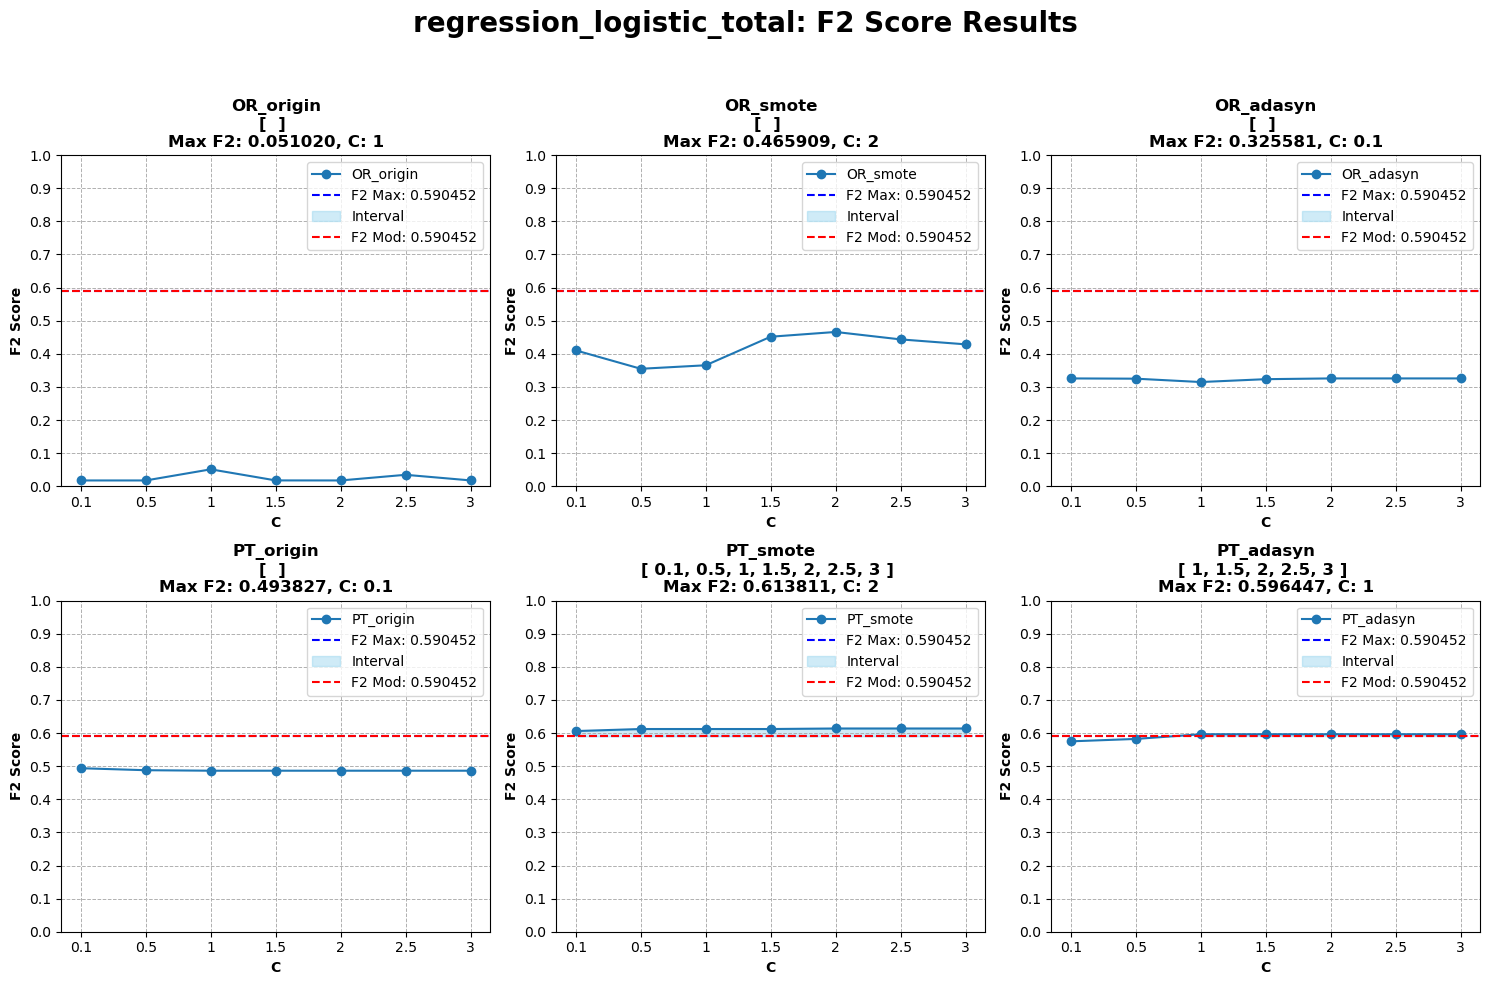

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,regression_logistic,PT smote,C=0.1,0.751542,0.802721,0.428571,0.676056,0.524590,0.606061,[[306 64]\n [ 23 48]]
1,regression_logistic,PT smote,C=0.5,0.756947,0.811791,0.444444,0.676056,0.536313,0.612245,[[310 60]\n [ 23 48]]
2,regression_logistic,PT smote,C=1,0.756947,0.811791,0.444444,0.676056,0.536313,0.612245,[[310 60]\n [ 23 48]]
3,regression_logistic,PT smote,C=1.5,0.756947,0.811791,0.444444,0.676056,0.536313,0.612245,[[310 60]\n [ 23 48]]
4,regression_logistic,PT smote,C=2,0.758298,0.814059,0.448598,0.676056,0.539326,0.613811,[[311 59]\n [ 23 48]]
5,regression_logistic,PT smote,C=2.5,0.758298,0.814059,0.448598,0.676056,0.539326,0.613811,[[311 59]\n [ 23 48]]
6,regression_logistic,PT smote,C=3,0.758298,0.814059,0.448598,0.676056,0.539326,0.613811,[[311 59]\n [ 23 48]]
7,regression_logistic,PT adasyn,C=1,0.745851,0.802721,0.427273,0.661972,0.519337,0.596447,[[307 63]\n [ 24 47]]
8,regression_logistic,PT adasyn,C=1.5,0.745851,0.802721,0.427273,0.661972,0.519337,0.596447,[[307 63]\n [ 24 47]]
9,regression_logistic,PT adasyn,C=2,0.745851,0.802721,0.427273,0.661972,0.519337,0.596447,[[307 63]\n [ 24 47]]


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,regression_logistic,PT smote,C=2,0.758298,0.814059,0.448598,0.676056,0.539326,0.613811,[[311 59]\n [ 23 48]]
1,regression_logistic,PT smote,C=2.5,0.758298,0.814059,0.448598,0.676056,0.539326,0.613811,[[311 59]\n [ 23 48]]
2,regression_logistic,PT smote,C=3,0.758298,0.814059,0.448598,0.676056,0.539326,0.613811,[[311 59]\n [ 23 48]]


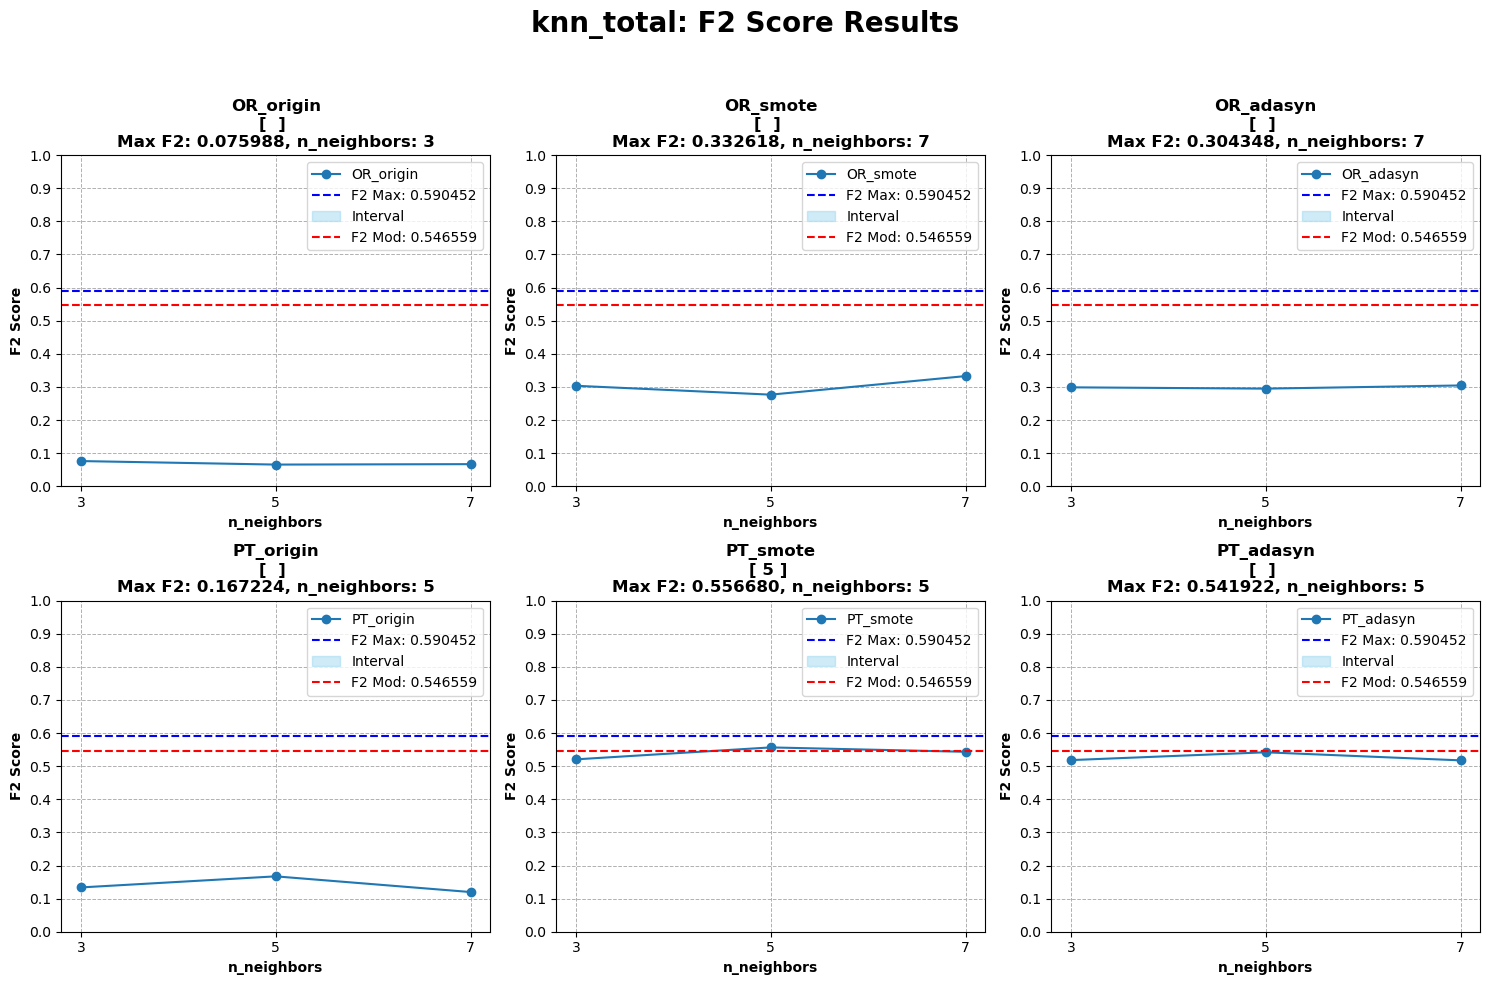

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,knn,PT smote,n_neighbors=5,0.677864,0.612245,0.261905,0.774648,0.391459,0.55668,[[215 155]\n [ 16 55]]


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,knn,PT smote,n_neighbors=5,0.677864,0.612245,0.261905,0.774648,0.391459,0.55668,[[215 155]\n [ 16 55]]


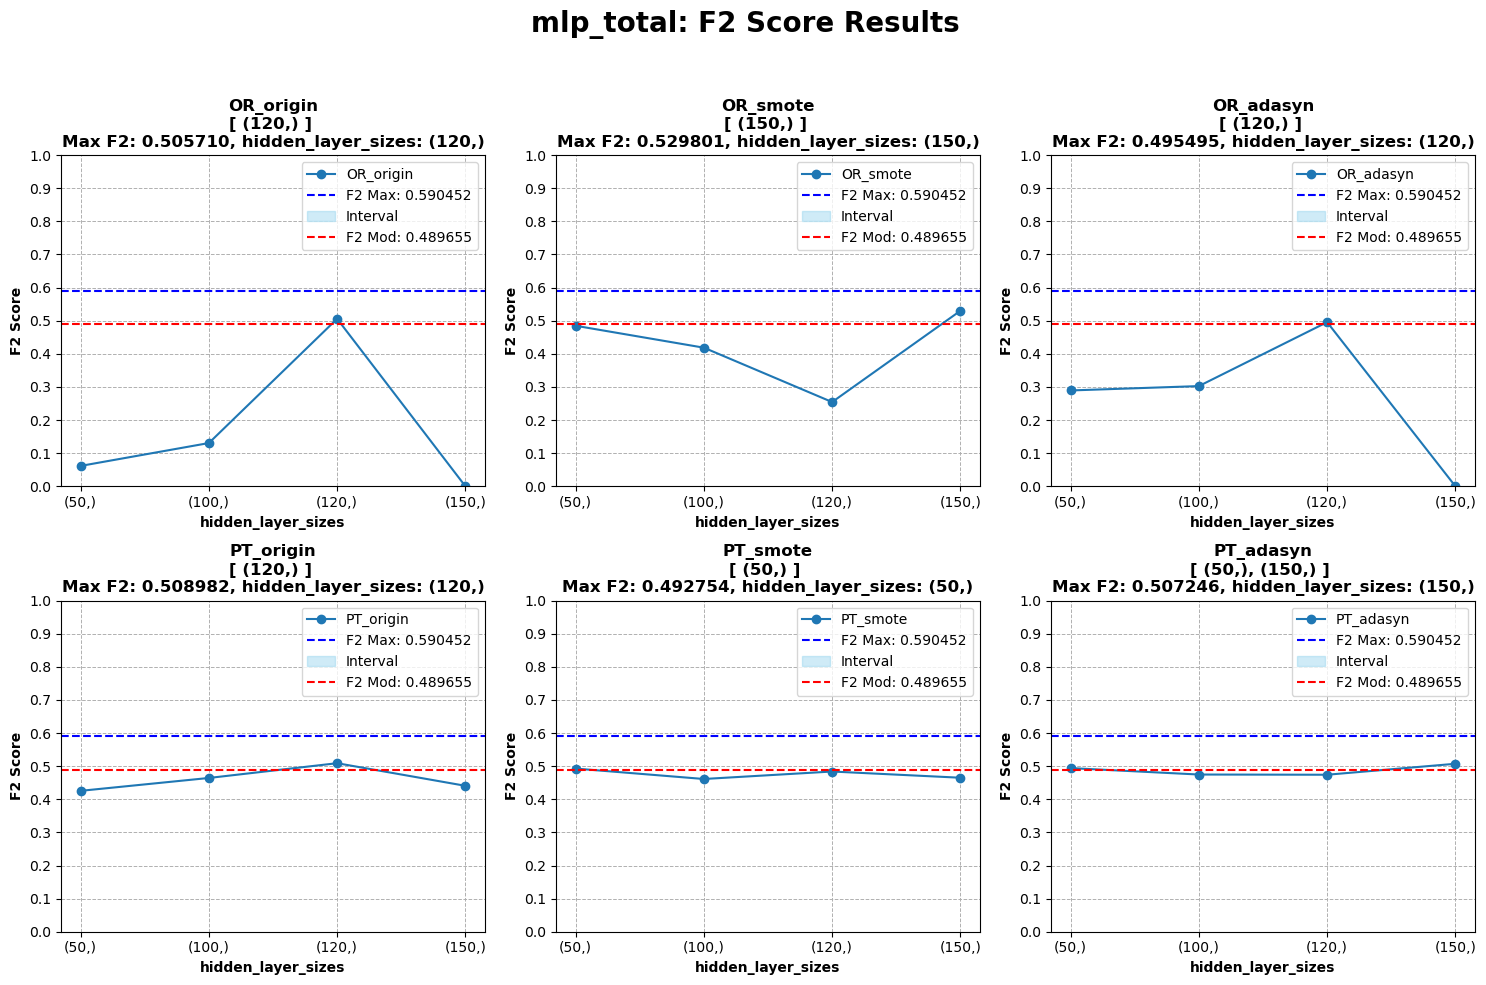

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,mlp,OR origin,"hidden_layer_sizes=(120,)",0.575809,0.374150,0.188450,0.873239,0.310000,0.505710,[[103 267]\n [ 9 62]]
1,mlp,OR smote,"hidden_layer_sizes=(150,)",0.604758,0.403628,0.200000,0.901408,0.327366,0.529801,[[114 256]\n [ 7 64]]
2,mlp,OR adasyn,"hidden_layer_sizes=(120,)",0.537762,0.272109,0.172775,0.929577,0.291391,0.495495,[[ 54 316]\n [ 5 66]]
3,mlp,PT origin,"hidden_layer_sizes=(120,)",0.717815,0.879819,0.680000,0.478873,0.561983,0.508982,[[354 16]\n [ 37 34]]
4,mlp,PT smote,"hidden_layer_sizes=(50,)",0.702950,0.854875,0.557377,0.478873,0.515152,0.492754,[[343 27]\n [ 37 34]]
5,mlp,PT adasyn,"hidden_layer_sizes=(50,)",0.704301,0.857143,0.566667,0.478873,0.519084,0.494186,[[344 26]\n [ 37 34]]
6,mlp,PT adasyn,"hidden_layer_sizes=(150,)",0.711344,0.859410,0.573770,0.492958,0.530303,0.507246,[[344 26]\n [ 36 35]]


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,mlp,OR smote,"hidden_layer_sizes=(150,)",0.604758,0.403628,0.2,0.901408,0.327366,0.529801,[[114 256]\n [ 7 64]]


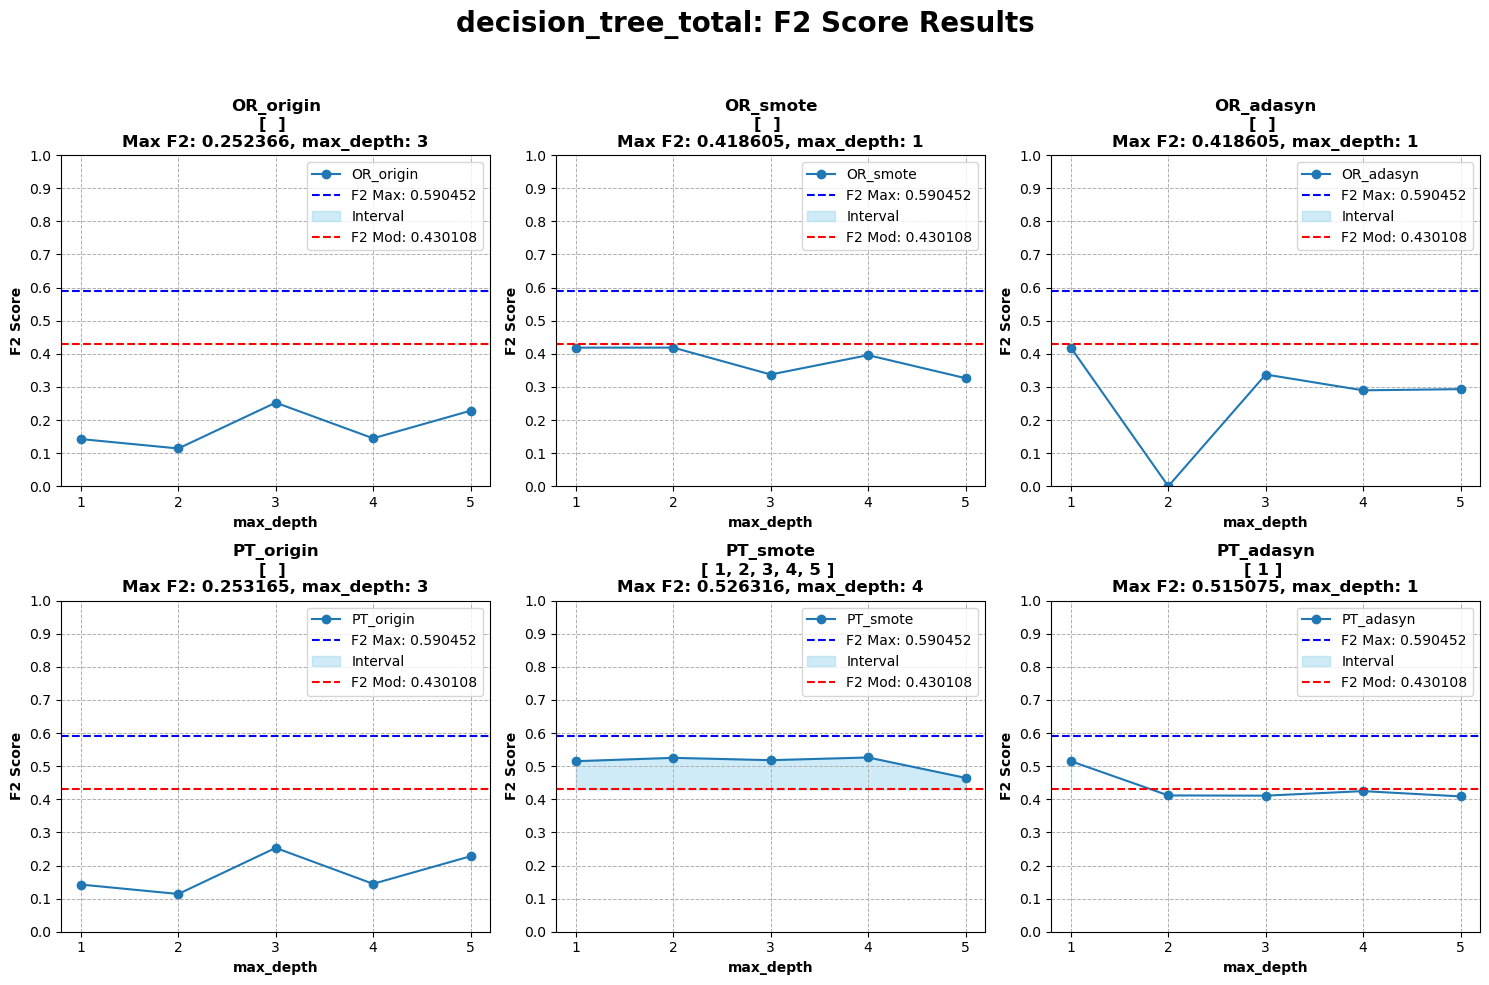

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,decision_tree,PT smote,max_depth=1,0.690084,0.766440,0.359649,0.577465,0.443243,0.515075,[[297 73]\n [ 30 41]]
1,decision_tree,PT smote,max_depth=2,0.660221,0.630385,0.260417,0.704225,0.380228,0.525210,[[228 142]\n [ 21 50]]
2,decision_tree,PT smote,max_depth=3,0.697906,0.789116,0.392157,0.563380,0.462428,0.518135,[[308 62]\n [ 31 40]]
3,decision_tree,PT smote,max_depth=4,0.706014,0.802721,0.416667,0.563380,0.479042,0.526316,[[314 56]\n [ 31 40]]
4,decision_tree,PT smote,max_depth=5,0.681043,0.827664,0.464789,0.464789,0.464789,0.464789,[[332 38]\n [ 38 33]]
5,decision_tree,PT adasyn,max_depth=1,0.690084,0.766440,0.359649,0.577465,0.443243,0.515075,[[297 73]\n [ 30 41]]


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,decision_tree,PT smote,max_depth=4,0.706014,0.802721,0.416667,0.56338,0.479042,0.526316,[[314 56]\n [ 31 40]]


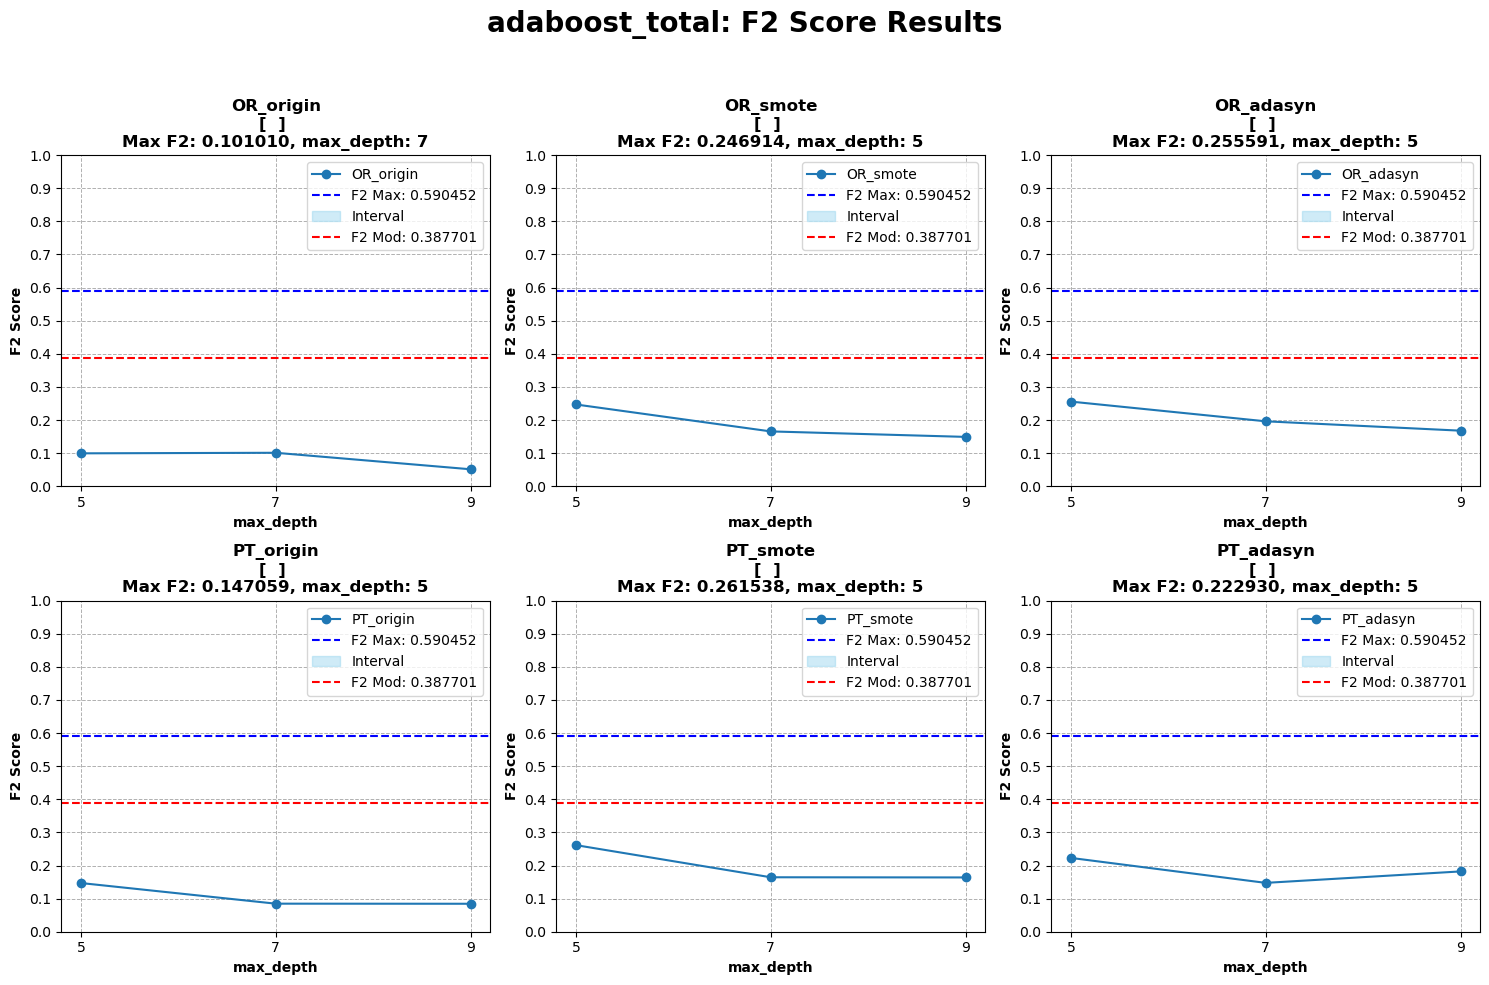

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,adaboost,PT smote,max_depth=5,0.587286,0.823129,0.414634,0.239437,0.303571,0.261538,[[346 24]\n [ 54 17]]


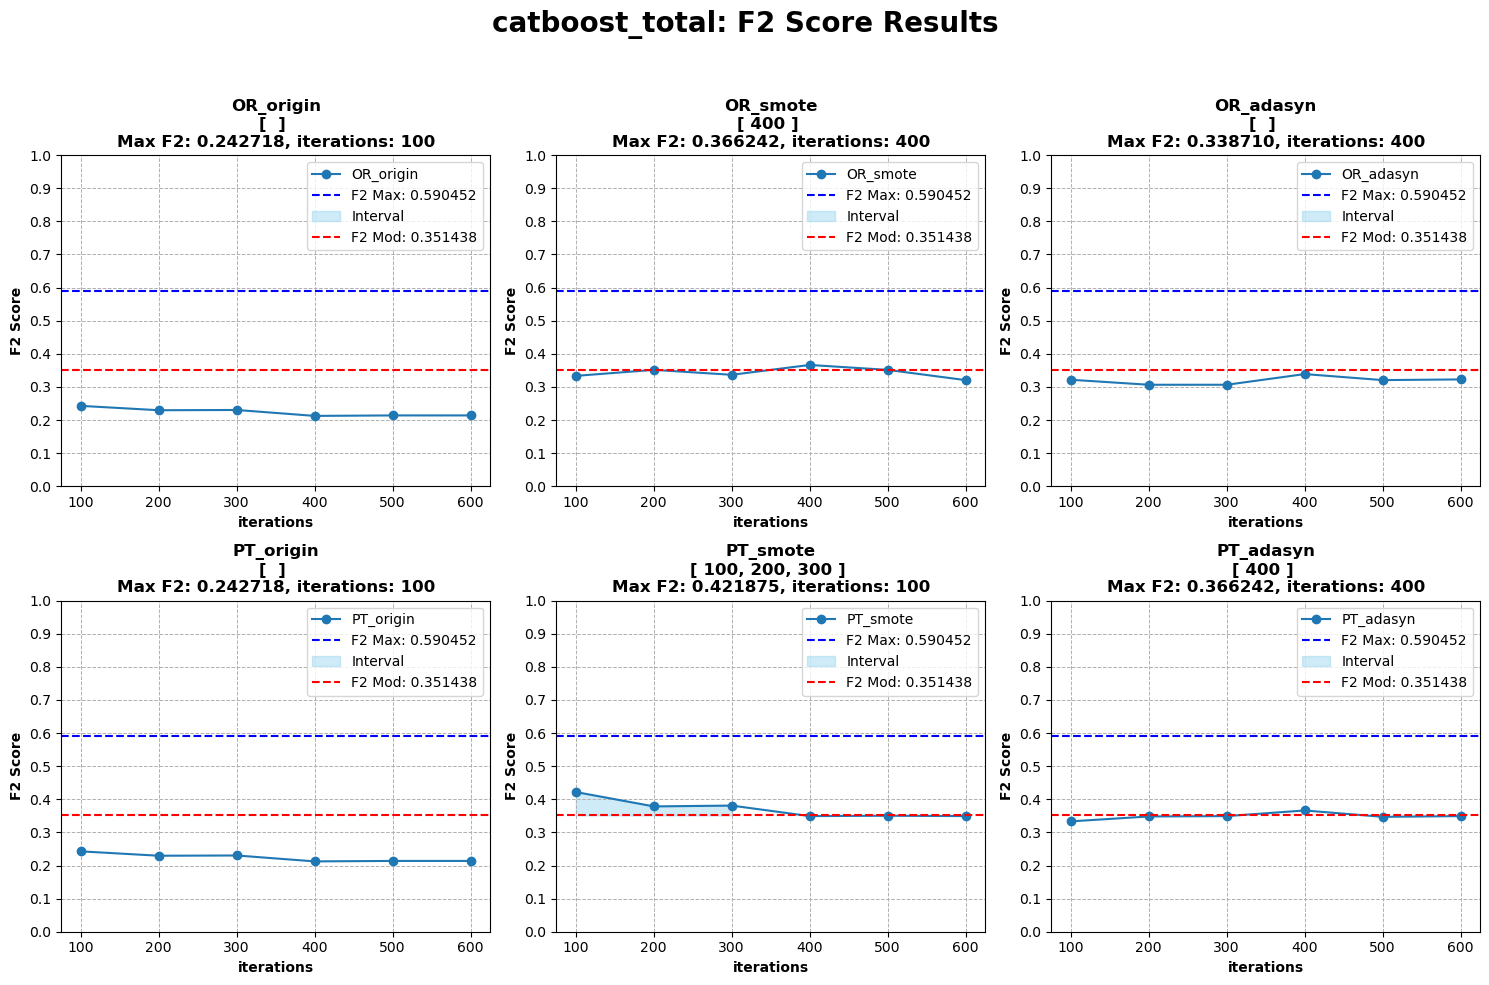

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,catboost,OR smote,iterations=400,0.652512,0.875283,0.766667,0.323944,0.455446,0.366242,[[363 7]\n [ 48 23]]
1,catboost,PT smote,iterations=100,0.677979,0.879819,0.750000,0.380282,0.504673,0.421875,[[361 9]\n [ 44 27]]
2,catboost,PT smote,iterations=200,0.656852,0.873016,0.727273,0.338028,0.461538,0.378549,[[361 9]\n [ 47 24]]
3,catboost,PT smote,iterations=300,0.659555,0.877551,0.774194,0.338028,0.470588,0.380952,[[363 7]\n [ 47 24]]
4,catboost,PT adasyn,iterations=400,0.652512,0.875283,0.766667,0.323944,0.455446,0.366242,[[363 7]\n [ 48 23]]


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,catboost,PT smote,iterations=100,0.677979,0.879819,0.75,0.380282,0.504673,0.421875,[[361 9]\n [ 44 27]]


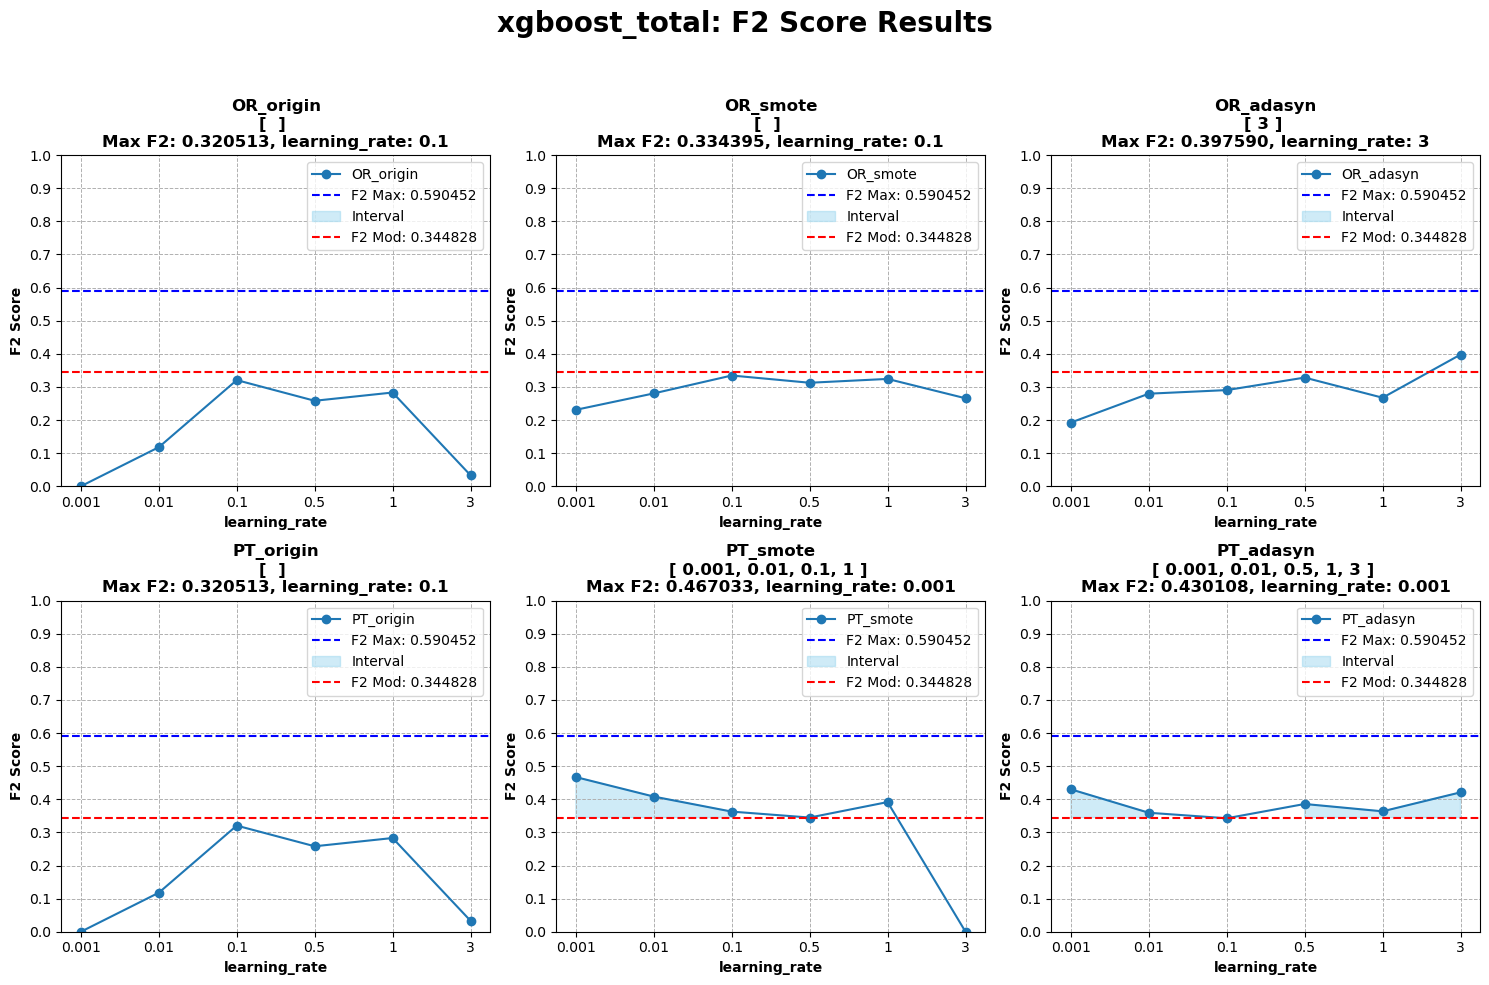

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,xgboost,OR adasyn,learning_rate=3,0.599962,0.691610,0.251908,0.464789,0.326733,0.397590,[[272 98]\n [ 38 33]]
1,xgboost,PT smote,learning_rate=0.001,0.677274,0.811791,0.425000,0.478873,0.450331,0.467033,[[324 46]\n [ 37 34]]
2,xgboost,PT smote,learning_rate=0.01,0.655291,0.832200,0.474576,0.394366,0.430769,0.408163,[[339 31]\n [ 43 28]]
3,xgboost,PT smote,learning_rate=0.1,0.648458,0.868481,0.696970,0.323944,0.442308,0.362776,[[360 10]\n [ 48 23]]
4,xgboost,PT smote,learning_rate=1,0.653369,0.848073,0.541667,0.366197,0.436975,0.391566,[[348 22]\n [ 45 26]]
5,xgboost,PT adasyn,learning_rate=0.001,0.649676,0.784580,0.363636,0.450704,0.402516,0.430108,[[314 56]\n [ 39 32]]
6,xgboost,PT adasyn,learning_rate=0.01,0.633879,0.834467,0.480000,0.338028,0.396694,0.359281,[[344 26]\n [ 47 24]]
7,xgboost,PT adasyn,learning_rate=0.5,0.655786,0.861678,0.625000,0.352113,0.450450,0.385802,[[355 15]\n [ 46 25]]
8,xgboost,PT adasyn,learning_rate=1,0.639284,0.843537,0.521739,0.338028,0.410256,0.363636,[[348 22]\n [ 47 24]]
9,xgboost,PT adasyn,learning_rate=3,0.508584,0.385488,0.164430,0.690141,0.265583,0.420962,[[121 249]\n [ 22 49]]


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,xgboost,PT smote,learning_rate=0.001,0.677274,0.811791,0.425,0.478873,0.450331,0.467033,[[324 46]\n [ 37 34]]


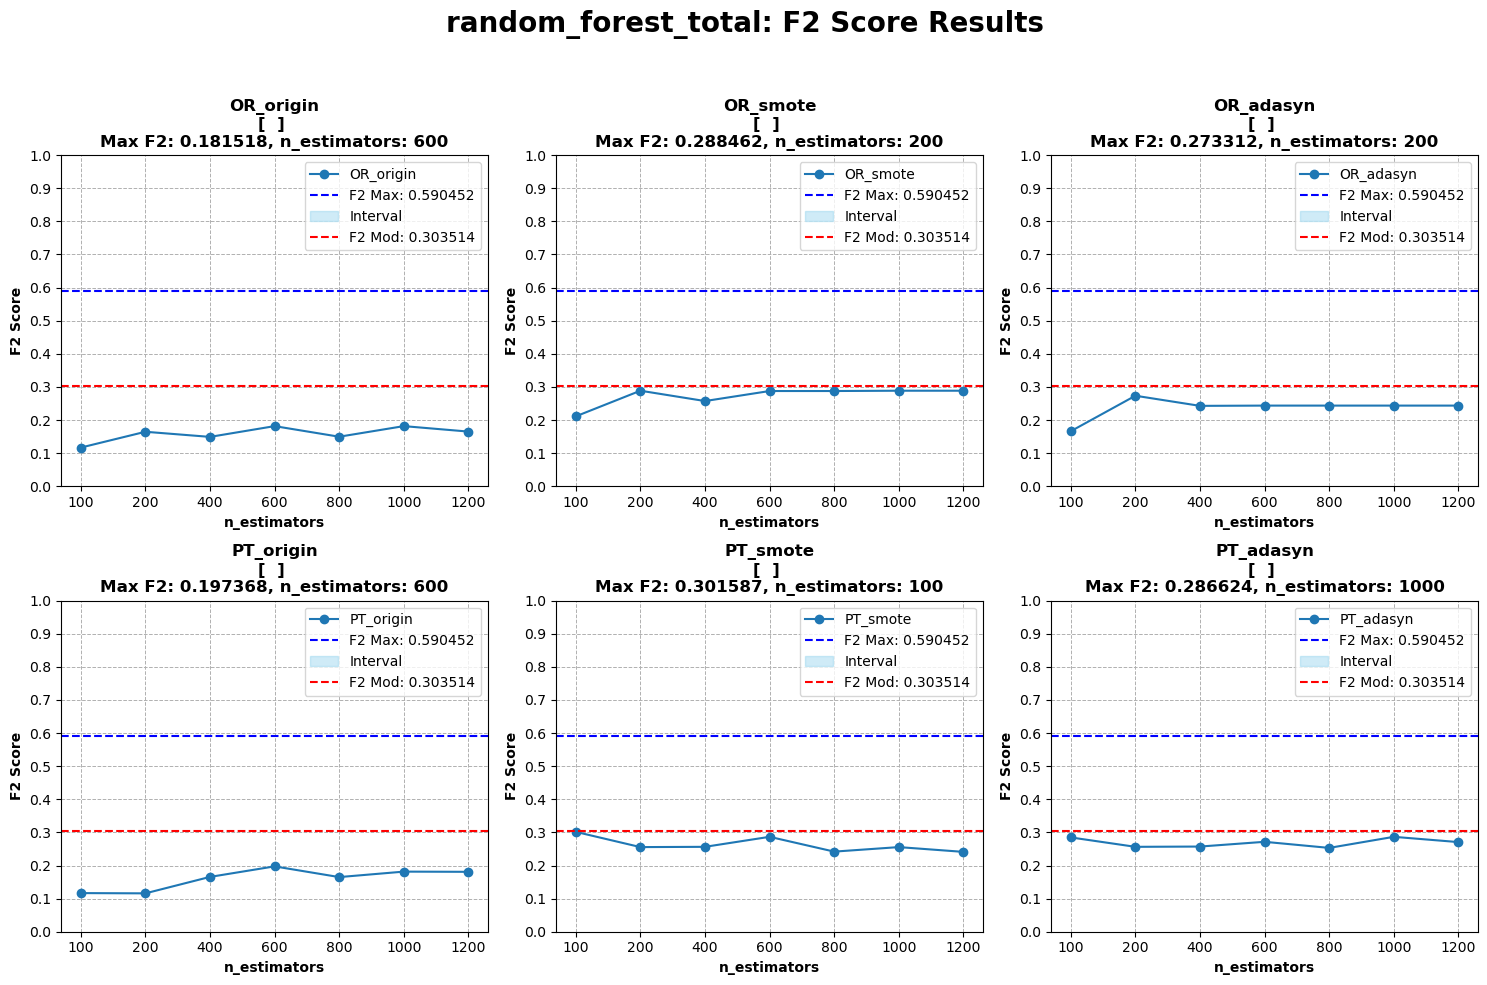

,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix


,Model,Description,Parameter,ROC-AUC,Accuracy,Precision,Recall,F1 Score,F2 Score,Confusion Matrix
0,random_forest,PT smote,n_estimators= 100,0.617587,0.854875,0.612903,0.267606,0.372549,0.301587,[[358 12]\n [ 52 19]]


In [19]:
# Iterate over the models and plot
for model_f2score in model_f2score_result1:
    # Get the DataFrame corresponding to the model
    data = globals().get(model_f2score[1])  # Use the model name to get the DataFrame
    if data is not None:
        full_model(model_f2score, data, path_photos, complete_model_directory, best_model_directory)      
    else:
        print(f"DataFrame para el modelo: {model_f2score[1]} no se ha encontrado.")

In [ ]:
# Load default files [Models with default settings]:
print ("Load data models with best value settings:\n----------------------------------------------")
load_files(model_list, best_model, best_model_directory)

In [ ]:
# List to store DataFrames with the maximum F2 Score
max_f2_scores = []

print("Loading best_model files:\n===============================\n")
# Loop to iterate over the model names and select the DataFrame with the maximum F2 Score
for model in model_list:
    # Build the original variable name
    model_var_name = f"{model}_best_model"
    # Get the DataFrame corresponding to that variable using globals()
    model_df = globals()[model_var_name]
    print(model_var_name)
    # Select the row with the maximum value in 'F2 Score'
    model_max_df = model_df.loc[[model_df['F2 Score'].idxmax()]]
    # Add the result to the list
    max_f2_scores.append(model_max_df)

# Concatenate all DataFrames from the list into one
ranking_final = pd.concat(max_f2_scores)

# Insert a 'Parameter' column between 'Description' and 'ROC-AUC'
#ranking_final.insert(ranking_final.columns.get_loc('ROC-AUC'), 'Parameter', 'Default')

# Reset the index of the final DataFrame
ranking_final.reset_index(drop=True, inplace=True)

# Now 'ranking_final' contains the DataFrames with the maximum F2 Score of each model
#print ("\n\n\nFinal Ranking:\n===============")
ranking_final = ranking_final.sort_values('F2 Score', ascending=False)
ranking_final.reset_index(drop=True, inplace=True)

In [ ]:
ranking_final = create_ranking(model_list,'_best_model')
ranking_final_sorted = ranking_final.sort_values(by='F2 Score', ascending=False)
ranking_final_sorted .reset_index(drop=True, inplace=True) 
ranking_final_sorted